In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from dask.diagnostics import ProgressBar
import duckdb

sys.path.append("../../scripts")
from initial_map import BarcodeMapper
from map_refiner import MapRefiner
import preprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     reads_threshold = 5,
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")])

IOException: IO Error: Could not set lock on file "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/Sequencing errors/../../duckdb/CC_nkx2_2": Conflicting lock is held in /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/bin/python3.11 (PID 1251062). See also https://duckdb.org/docs/stable/connect/concurrency

In [5]:
refiner.refine_map_from_db()

NameError: name 'refiner' is not defined

In [1]:
#refiner.create_map1_initial('../output/CC_nkx2_2.parquet/*')
initial = refiner.get_map_df('map1_initial')
initial

NameError: name 'refiner' is not defined

In [230]:
# What is the distribution of reads for designed vs undesigned AD sequences?
initial_grouped = initial.groupby(['AD', 'Designed']).size().reset_index(name='count')
initial_grouped.sort_values(by = "count", ascending = False)

,AD,Designed,count
4149,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,852
117,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,1,739
244,ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...,1,738
520,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...,1,646
3095,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATC,0,636
...,...,...,...
2621,GCCCAGGACCTGGCCGCCAGCACCTTCCAGGCCGGCATTCCCTTCA...,0,1
2619,GCCCAGGACCTGGCCGCCAGCACCTTCCAGGCCGGCATTCCCTTCA...,0,1
2618,GCCCAGGACCTGGCCGCCAGCACCTTCCAGGCCGGCATTCCCTTCA...,0,1
2617,GCCCAGGACCTGGCCGCCAGCACCTTCCAGGCCGGCATTCCCTTCA...,0,1


In [231]:
initial_grouped[(initial_grouped["Designed"] == 0) & (initial_grouped["count"] > 5)]

,AD,Designed,count
85,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,0,61
116,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,0,7
127,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,0,26
203,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,0,24
236,ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...,0,48
...,...,...,...
7106,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGAGCTGG,0,130
7110,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGCTGTGG,0,261
7120,TATCCCACCGCCCATCCTCTGGTGCATGCCCAGCAGTGGACCTGGC...,0,33
7173,TCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,0,11


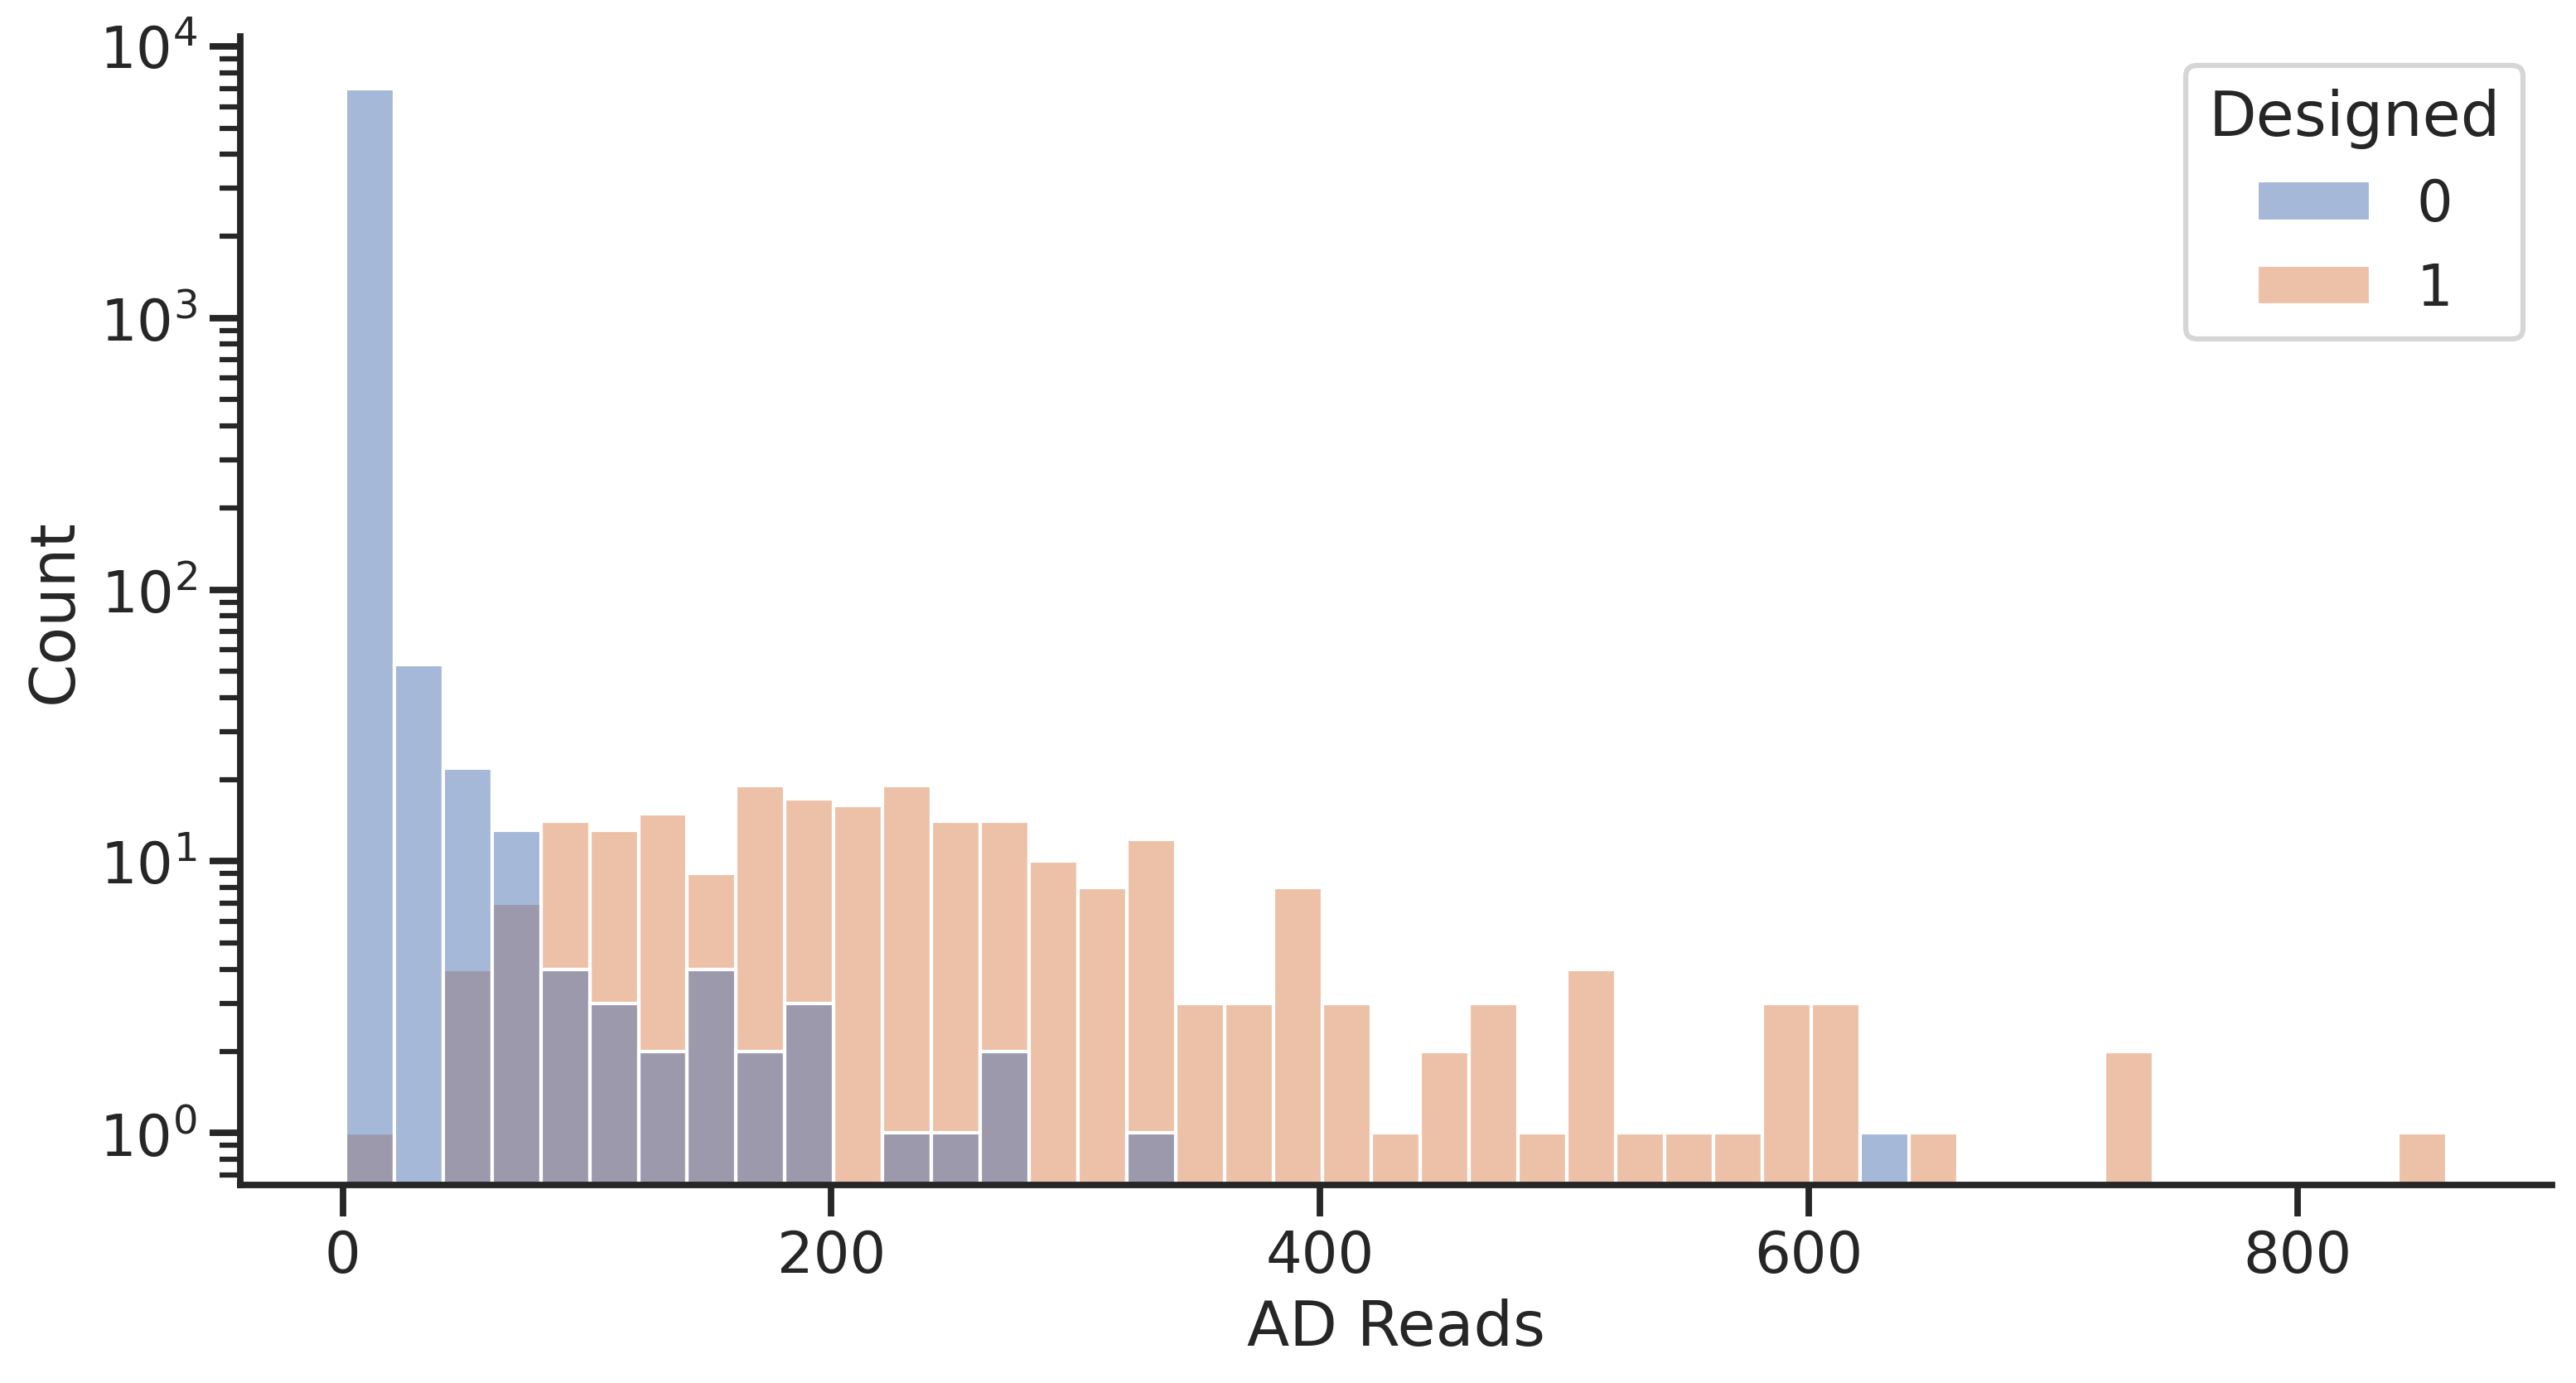

In [232]:
sns.set_theme(style="ticks", palette="deep", context='talk')
plt.figure(dpi = 300, figsize = (12,6))
ax = sns.histplot(data =initial_grouped[initial_grouped["count"] > 0] , x = 'count', hue = 'Designed', binwidth = 20, linewidth = 1)
ax.set_yscale('log')
sns.despine()
plt.xlabel("AD Reads")
plt.show();

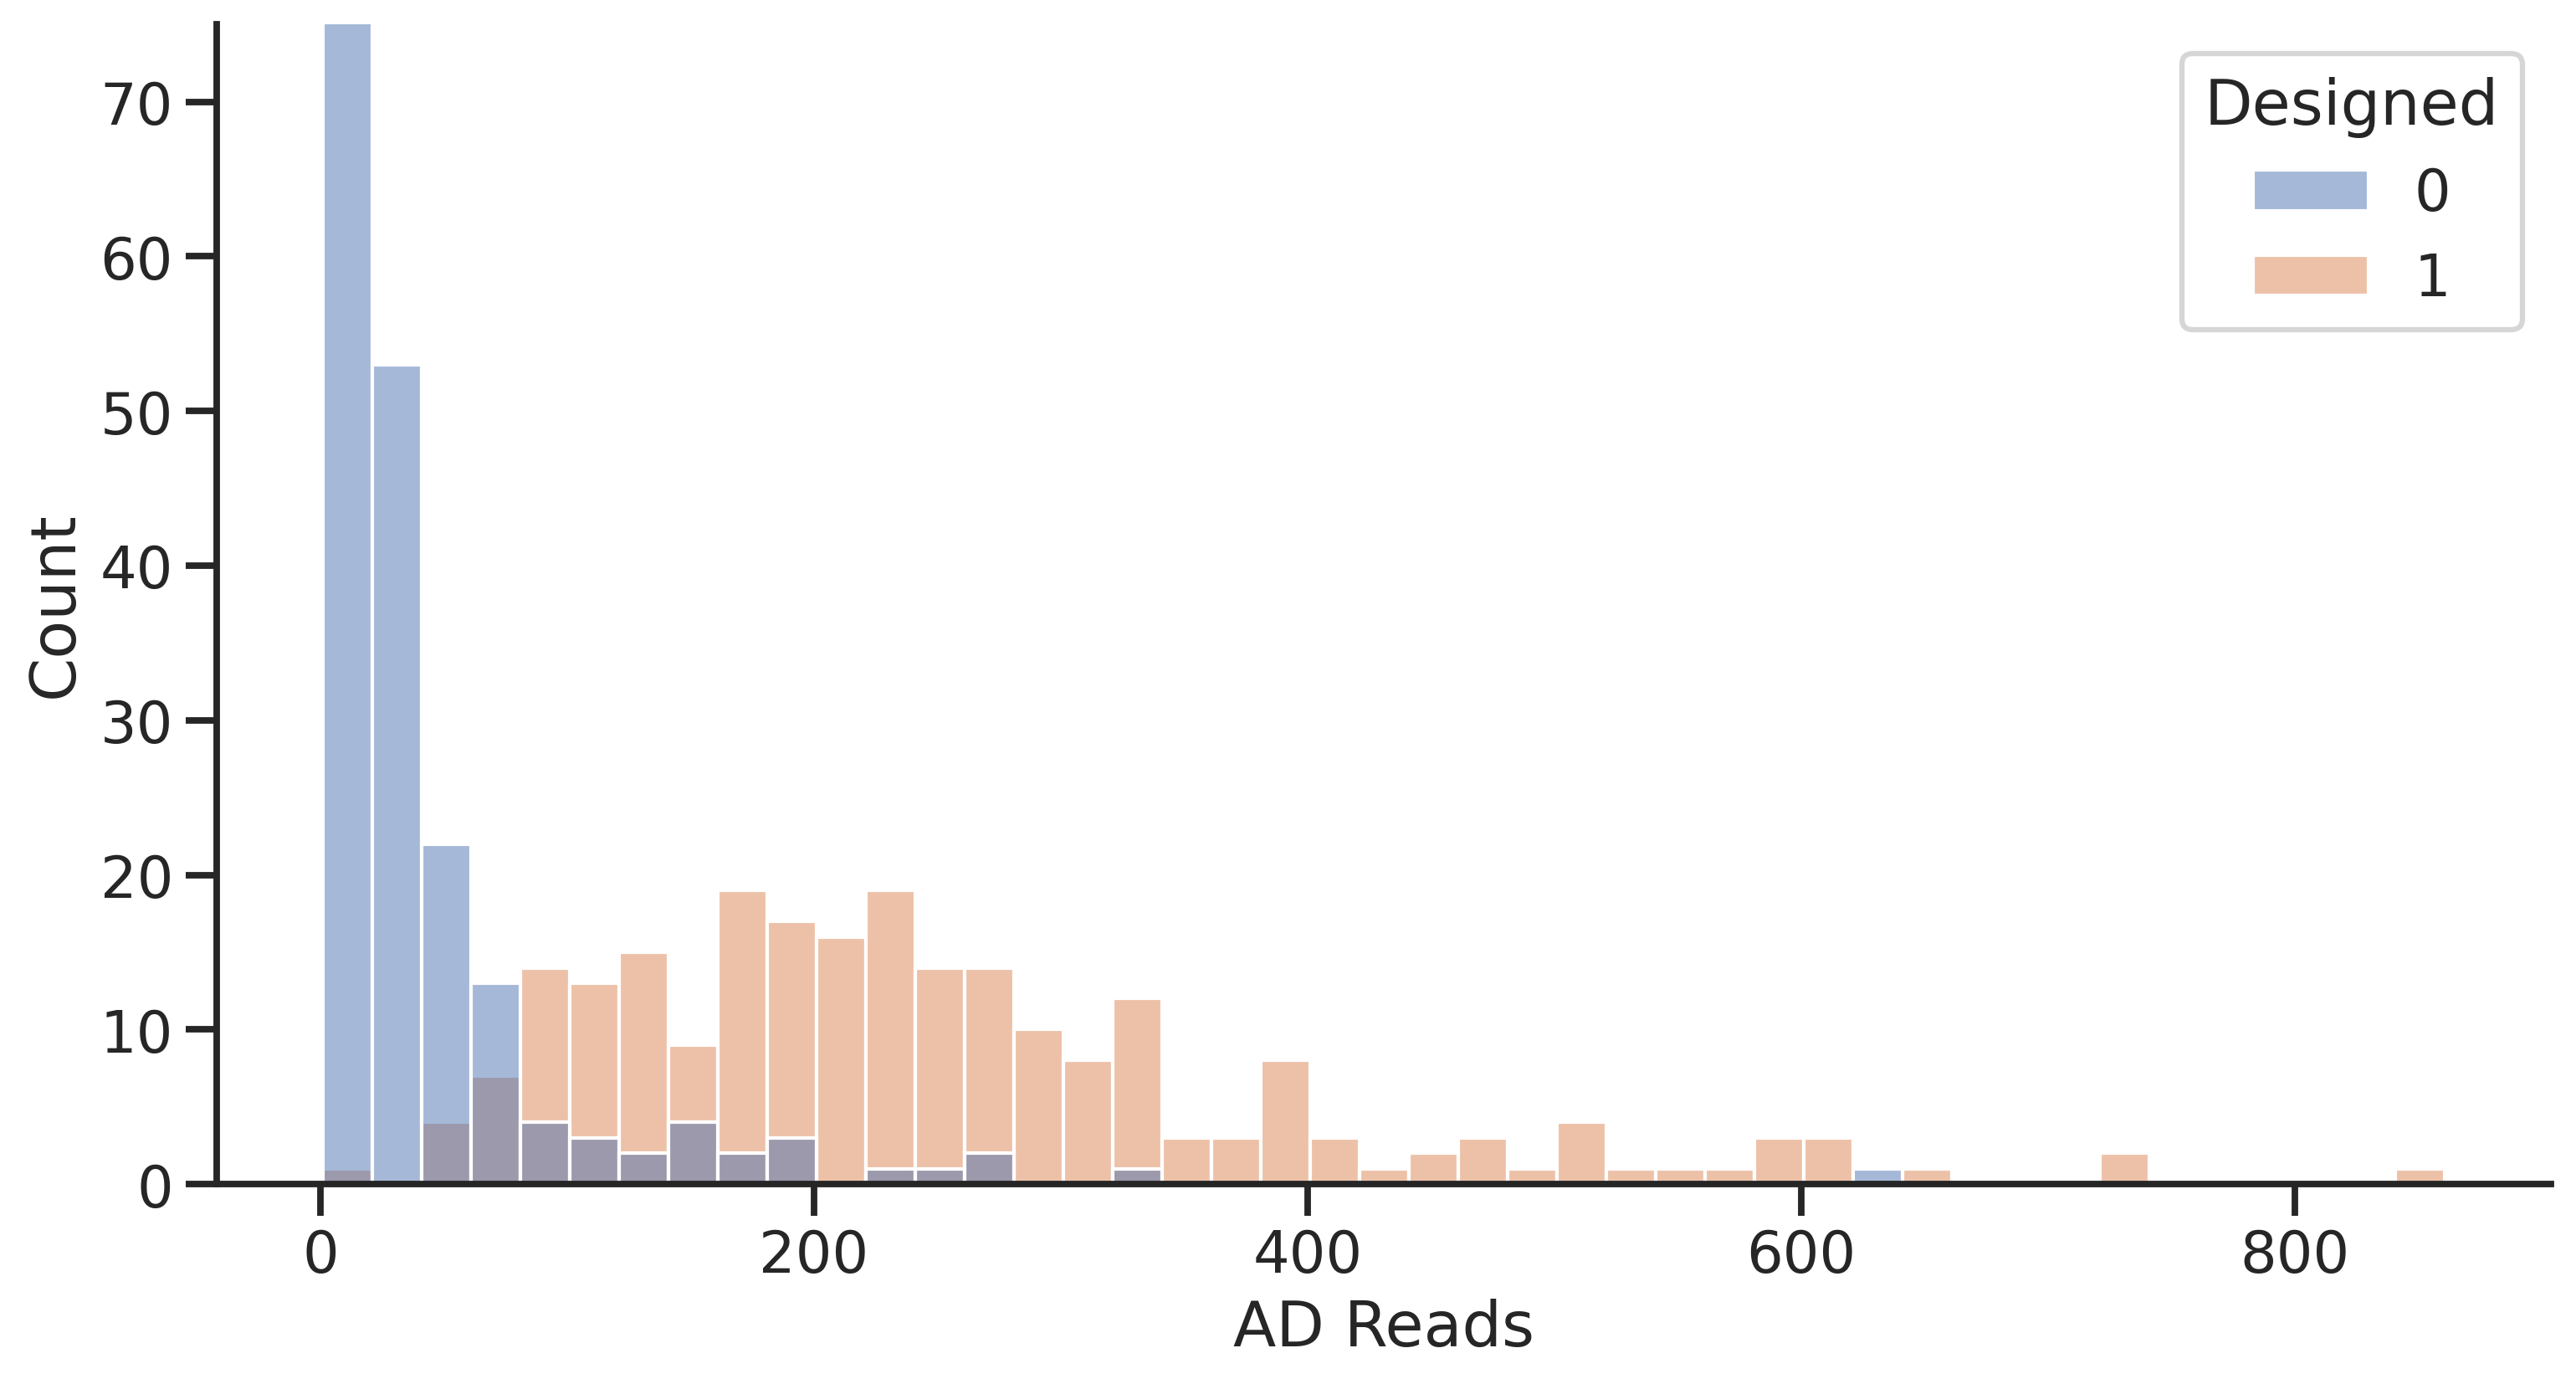

In [233]:
sns.set_theme(style="ticks", palette="deep", context='talk')
plt.figure(dpi = 300, figsize = (12,6))
ax = sns.histplot(data =initial_grouped[initial_grouped["count"] > 0] , x = 'count', hue = 'Designed', binwidth = 20, linewidth = 1)
sns.despine()
plt.xlabel("AD Reads")
plt.ylim(0, 75)
plt.show();

In [234]:
# Are there rows where designed and designed ADs share an AD BC?
initial

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,None,False,None,False,None,False,None,False,0
1,None,False,ACCAAGATC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0
2,None,False,None,False,None,False,None,False,0
3,None,False,None,False,None,False,None,False,0
4,None,False,None,False,None,False,None,False,0
...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1


In [235]:
initial_read_counts = pd.DataFrame(initial.value_counts()).reset_index()
initial_read_counts

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,count
0,CCATAA,True,CACCGATTG,True,CAGCGTTTAACAAGCG,True,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,True,1,293
1,ACCCCC,True,ATCCGCTGT,True,TGAAACGTTTAAGGGA,True,GCCCAGGACCCAGTGGACCTGG,False,0,224
2,ACAAGA,True,AGATCGAAG,True,GCAAATTAATGATGTC,True,GCCCAGGAGCAGTGGACCTGG,False,0,220
3,AAATAT,True,ATTGAACGG,True,GTGATTTAGTATCTTT,True,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGCTGTGG,False,0,217
4,GTCAGC,True,CCATTAACG,True,TGTAAAATGGGGCTGG,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1,203
...,...,...,...,...,...,...,...,...,...,...
14896,CACGTA,True,AGTCGCTAT,True,GGCAATATAACAGAAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,1
14897,CACGTA,True,AGTCGCTAT,True,GGCAATATAACAGAAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCC...,True,0,1
14898,CACGTA,True,AGTCGCTAT,True,GGCAATATAACAGAAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCC...,True,0,1
14899,CACGTA,True,AGTCGCTAT,True,GGCAATATAACAGAAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCC...,True,0,1


In [236]:
initial_read_counts_filtered = initial_read_counts[initial_read_counts["count"] > 5]
initial_read_counts_filtered

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,count
0,CCATAA,True,CACCGATTG,True,CAGCGTTTAACAAGCG,True,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,True,1,293
1,ACCCCC,True,ATCCGCTGT,True,TGAAACGTTTAAGGGA,True,GCCCAGGACCCAGTGGACCTGG,False,0,224
2,ACAAGA,True,AGATCGAAG,True,GCAAATTAATGATGTC,True,GCCCAGGAGCAGTGGACCTGG,False,0,220
3,AAATAT,True,ATTGAACGG,True,GTGATTTAGTATCTTT,True,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGCTGTGG,False,0,217
4,GTCAGC,True,CCATTAACG,True,TGTAAAATGGGGCTGG,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1,203
...,...,...,...,...,...,...,...,...,...,...
1776,AGCTAA,True,ACACTCTAG,True,TATCGTGTCCTTATAG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,6
1777,GTGTAC,True,CCATATTCG,True,AACAAATTAAAAAAGG,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1,6
1778,AACTAA,True,ATTCTCGCC,True,CTACATTAAGAAGCTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,6
1779,TGCATG,True,ATAGGAAGG,True,TGGATATATAATGGGC,True,GCCCAGAAGCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,6


In [243]:
initial_read_counts_filtered["concat_ADBC"] = initial_read_counts_filtered["ADBC2"] + initial_read_counts_filtered["HawkBCs"]
initial_read_counts_filtered

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,count,concat_ADBC
0,CCATAA,True,CACCGATTG,True,CAGCGTTTAACAAGCG,True,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,True,1,293,CCATAACACCGATTG
1,ACCCCC,True,ATCCGCTGT,True,TGAAACGTTTAAGGGA,True,GCCCAGGACCCAGTGGACCTGG,False,0,224,ACCCCCATCCGCTGT
2,ACAAGA,True,AGATCGAAG,True,GCAAATTAATGATGTC,True,GCCCAGGAGCAGTGGACCTGG,False,0,220,ACAAGAAGATCGAAG
3,AAATAT,True,ATTGAACGG,True,GTGATTTAGTATCTTT,True,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGCTGTGG,False,0,217,AAATATATTGAACGG
4,GTCAGC,True,CCATTAACG,True,TGTAAAATGGGGCTGG,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1,203,GTCAGCCCATTAACG
...,...,...,...,...,...,...,...,...,...,...,...
1776,AGCTAA,True,ACACTCTAG,True,TATCGTGTCCTTATAG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,6,AGCTAAACACTCTAG
1777,GTGTAC,True,CCATATTCG,True,AACAAATTAAAAAAGG,True,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,True,1,6,GTGTACCCATATTCG
1778,AACTAA,True,ATTCTCGCC,True,CTACATTAAGAAGCTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,6,AACTAAATTCTCGCC
1779,TGCATG,True,ATAGGAAGG,True,TGGATATATAATGGGC,True,GCCCAGAAGCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,6,TGCATGATAGGAAGG


In [244]:
bc_design_status = initial_read_counts_filtered.groupby("concat_ADBC")["Designed"].nunique()
shared_barcodes = bc_design_status[bc_design_status > 1].index
shared_rows = initial_read_counts_filtered[initial_read_counts_filtered['concat_ADBC'].isin(shared_barcodes)]
shared_rows

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,count,concat_ADBC
63,AGCATT,True,ACTCTTGCA,True,AGTTACAGAATCATAA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,79,AGCATTACTCTTGCA
99,TGACAC,True,ATACCGTCG,True,ACAAGAAGATATGTAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCAGCTTCA...,True,1,68,TGACACATACCGTCG
134,GAACAC,True,AGGTAGCTC,True,AGAAGACGTGGTTATT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGCCCTTCA...,True,1,61,GAACACAGGTAGCTC
162,ACATAT,True,AGCTGTTGG,True,TTGACTGAAACAAAAG,True,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,True,1,58,ACATATAGCTGTTGG
170,GACGAG,True,AGGTTCGAC,True,ATTTGCGAGCCGGAAT,True,CAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCA...,True,1,56,GACGAGAGGTTCGAC
205,TGATAA,True,CAGACAGCA,True,GCTTAATGTTGGATAG,True,GCCACCGACCTGGCCGCCGCCACCTTCACCGCCGGCATTCCCTTCA...,True,1,53,TGATAACAGACAGCA
402,ATAAAC,True,AGTCCAGTT,True,TTGAACCTCTGGCAAC,True,TATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGGC...,True,1,40,ATAAACAGTCCAGTT
407,ATAACT,True,AACAACGGT,True,GACTACCGTTGGTAAG,True,TACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCG...,True,1,40,ATAACTAACAACGGT
463,TGATAA,True,CAGACAGCA,True,GCTTAATGTTGGATAG,True,GCCACCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,37,TGATAACAGACAGCA
488,ATGAGA,True,AGCTTACGG,True,GTGAAACTCAATTAGC,True,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,True,1,36,ATGAGAAGCTTACGG


In [245]:
#refiner.create_map1_initial('../output/CC_nkx2_2.parquet/*')
map5_thresholded = refiner.get_map_df('map5_unique_target')
map5_thresholded

,ADBC2,HawkBCs,RTBC,AD,count
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,293
1,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,203
2,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,163
3,AGTAAA,CCGCAGTTA,ACATATTCTTGAAGGA,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,159
4,ATTATT,CCGGAGAAT,CCGTTTCCATAAGTTT,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,147
...,...,...,...,...,...
1431,CTATAG,ACAGTCCTT,GAAGGGTAAGTAGTTT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,6
1432,TGACGA,AACCGCATA,TCCAACTTCAAGAATA,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,6
1433,ACCCGA,AGCATCATC,ACTACACCTTGTATTT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,6
1434,GATATA,CAGCCTCAA,ACATACCGTAAAGATG,GCCCAGGACCTGAGCAGCAGCACCTTCCAGGCCGGCATTCCCTTCA...,6


In [246]:
# Are there any AD BC2 which should have been removed?
len(map5_thresholded[map5_thresholded["ADBC2"].isin(shared_barcodes)])

0

In [247]:
map5_thresholded[map5_thresholded["ADBC2"].isin(shared_barcodes)]

,ADBC2,HawkBCs,RTBC,AD,count


In [248]:
102/1436

0.07103064066852367

In [249]:
refiner.close_connection()